In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Load in triplet stim elecResps and amplitudes

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity_cosine"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [72]:
clusters_t = 15
clusters_nt = 5
negll_thr = 0.95

In [53]:
p = 2
targets = np.array([197])
nontargets = np.array([220])

p_thr = 2/19
p_upper = 1
random_state = 0

<IPython.core.display.Javascript object>


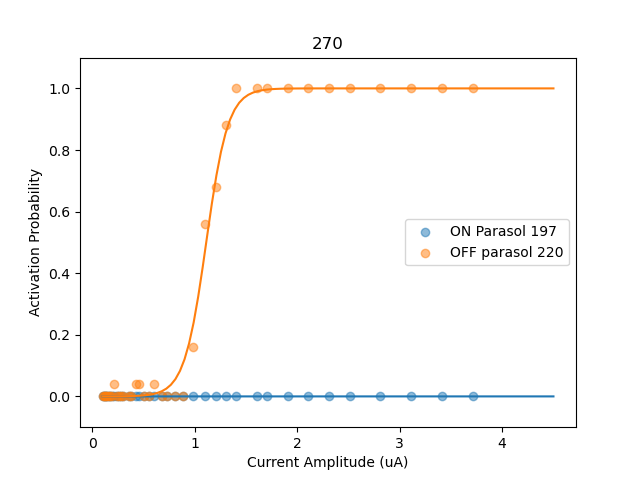

<IPython.core.display.Javascript object>


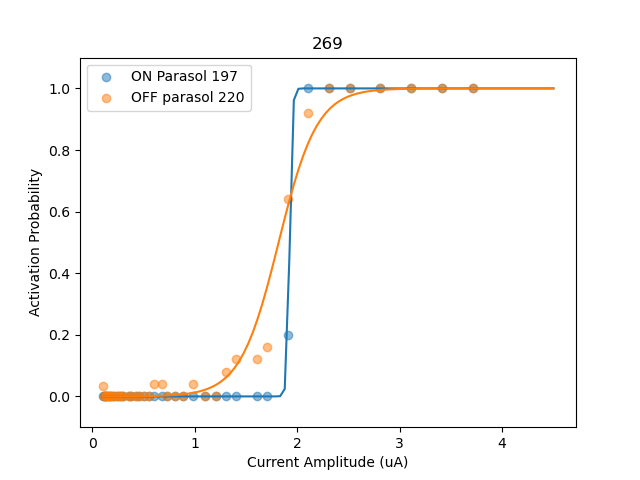

<IPython.core.display.Javascript object>


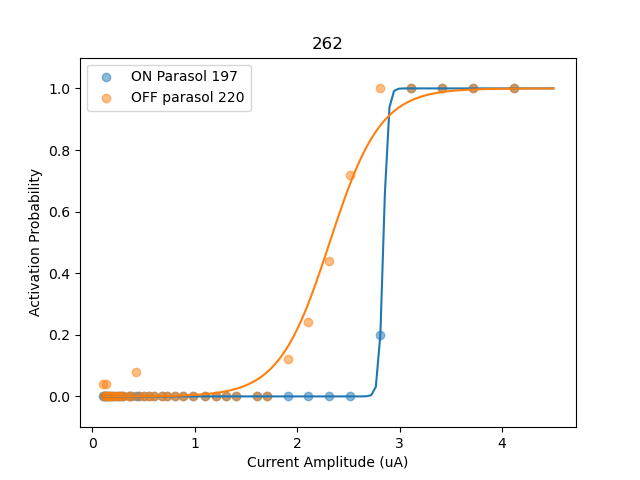

In [54]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
all_cells = np.sort(np.concatenate((targets, nontargets)).astype(int))
all_signals = []

for elec in triplet_elecs:
    filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
    plt.figure()
    plt.title(str(elec))
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Activation Probability')
    plt.xlabel('Current Amplitude (uA)')
    
    cell_signals = []
    for cell in all_cells:
        k = 0
        probs = []
        trials = []
        signals = []
        while True:
            try:
                with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                    prob_dict = pickle.load(f)
                    probs.append(prob_dict["cosine_prob"][0])
                    trials.append(prob_dict["num_trials"])
                    electrode_list = prob_dict["electrode_list"]
                                        
                signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                      elec, k)[:,electrode_list,:55]
                signals.append(signal)
            except:
                break
            
            k += 1
        
        cell_signals.append(signals)
        trials = np.array(trials, dtype=int)
        probs = np.array(probs)

        if len(probs) > 0:    
            probs = fitting.disambiguate_sigmoid(probs, spont_limit = 0.15, noise_limit = 0.1)

            X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))
        
            results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))
        
            currs = np.linspace(0.1, 4.5, 100)
            plt.plot(currs, fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x))
            plt.scatter(Ivals[:k], probs, alpha=0.5, 
                        label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))
    
    plt.legend()
    
    all_signals.append(cell_signals)
        

<IPython.core.display.Javascript object>


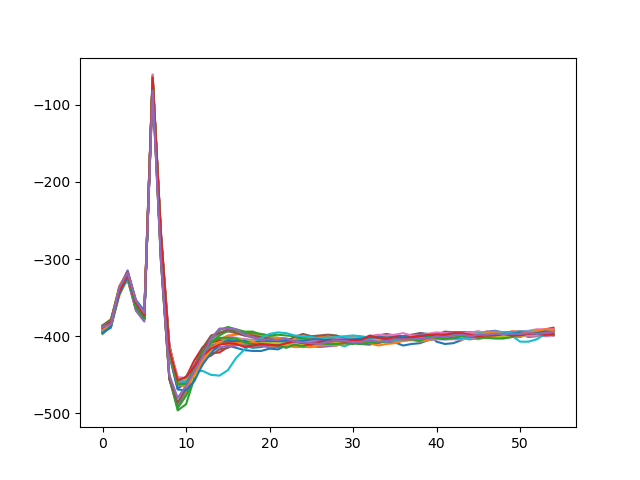

In [37]:
plt.figure()
plt.plot(all_signals[2][0][-1][:, 0, :].T);

In [55]:
def getWeights(p, n, n_clusters, nll_thr, points_per_cluster=50, selec_vec=np.zeros(3), show_clusters=False):
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            trials[k] = prob_dict["num_trials"]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(amplitudes[:, 0][good_inds], 
                amplitudes[:, 1][good_inds],
                amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
    if np.any(selec_vec != 0):
        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

    clustering = SpectralClustering(n_clusters=n_clusters, 
                                    assign_labels='discretize',
                                    affinity='nearest_neighbors', 
                                    random_state=random_state).fit(X)

    pp_weights = []
    for i in range(n_clusters):
        inds = np.where(clustering.labels_ == i)[0]

        if show_clusters:
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(X[inds, 0], 
                        X[inds, 1],
                        X[inds, 2], marker='o', s=20, c=y[inds], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()

        X_cluster = X[inds]
        y_cluster = y[inds]
        trials_cluster = trials[good_inds][inds]
        
        X_bin, y_bin = fitting.convertToBinaryClassifier(y_cluster, trials_cluster, X_cluster)
        
        results = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin, y_bin, False, 'none'))
        print(results.x)
        
        nll_MLE = fitting.negLL(results.x, X_bin, y_bin, False, 'none')        
        print(nll_MLE)
        
        if show_clusters:
            plt.figure()
            plt.scatter(fitting.fsigmoid(sm.add_constant(X_cluster, has_constant='add'), results.x), y_cluster)
            plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c='k', linestyle='--')

        if nll_MLE < nll_thr and results.x[0] < 0 and len(inds) > points_per_cluster:
            pp_weights.append(results.x)

    return np.array(pp_weights), amplitudes, triplet_probs

OFF parasol


<IPython.core.display.Javascript object>


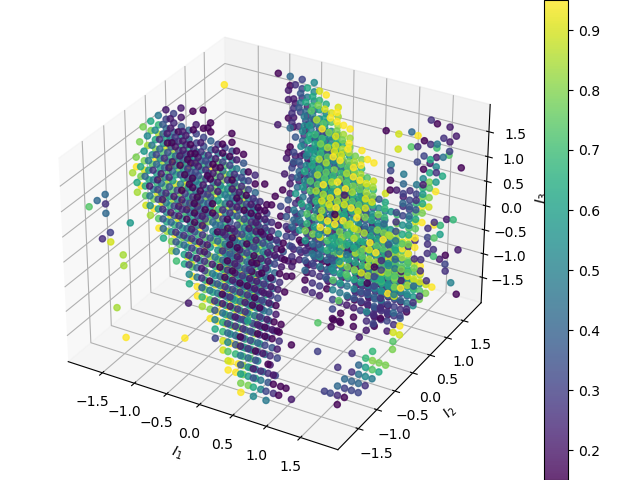

/tmp/ipykernel_26826/2848077523.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


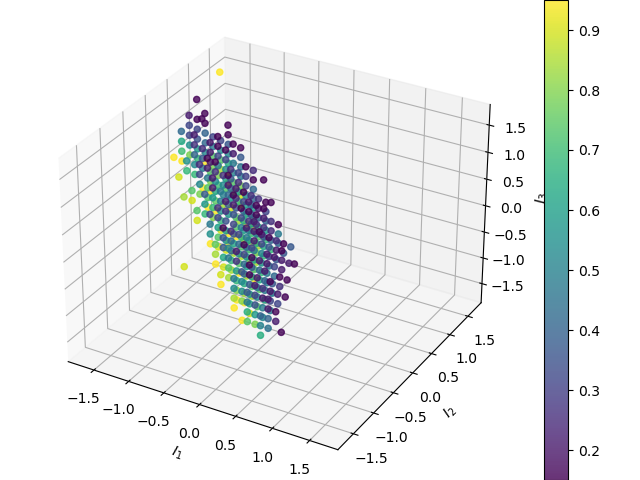

[-6.53564193 -6.149421   -2.96013467 -3.01433535]
0.8466117010625431


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


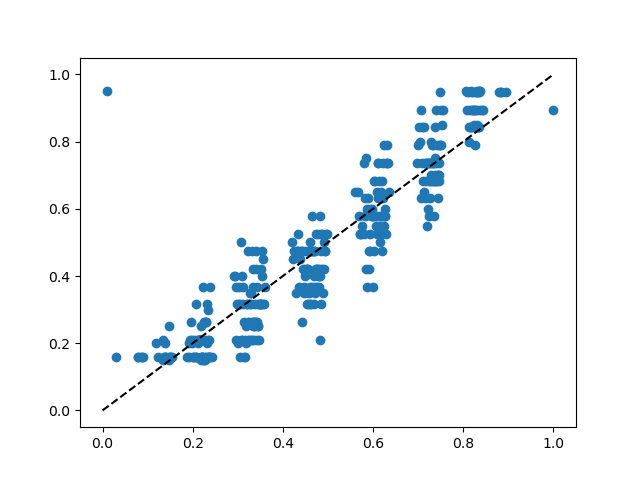

/tmp/ipykernel_26826/2848077523.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


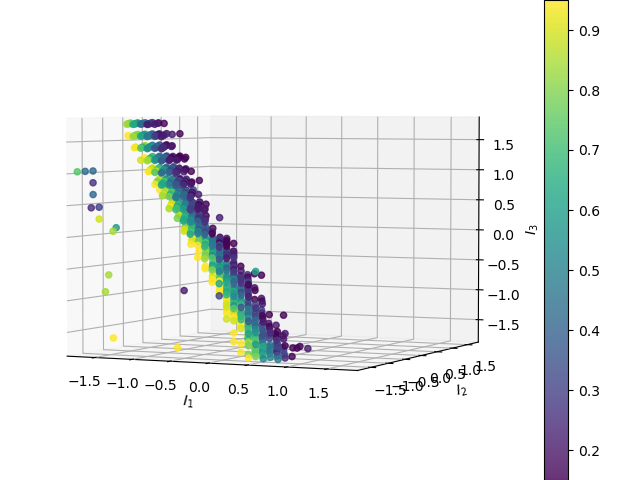

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-4.20781946 -4.07088449 -2.11506443 -2.0416061 ]
0.9047272231383936


<IPython.core.display.Javascript object>


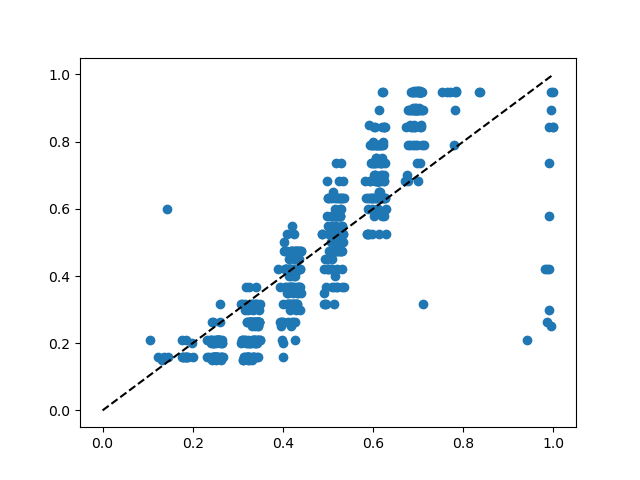

<IPython.core.display.Javascript object>


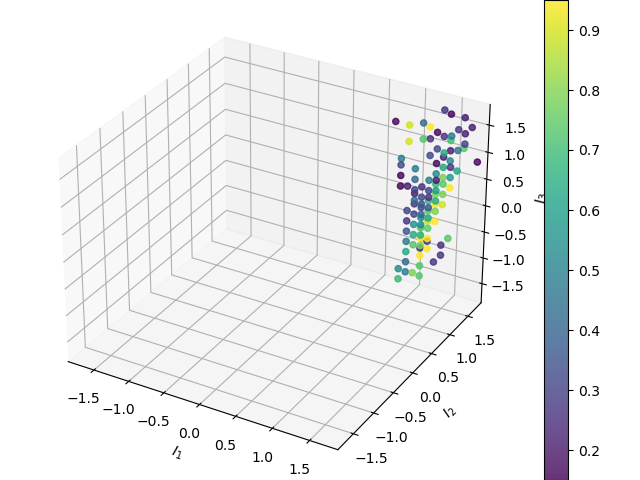

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[ 0.87853236 -0.24192129  0.18920753 -0.67683766]
0.9729693992263188


<IPython.core.display.Javascript object>


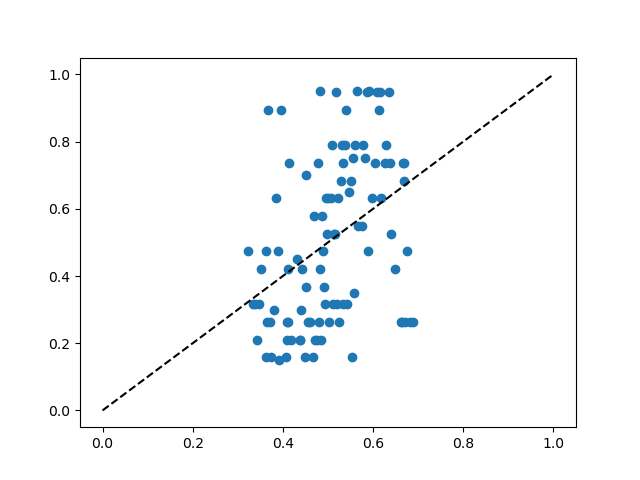

<IPython.core.display.Javascript object>


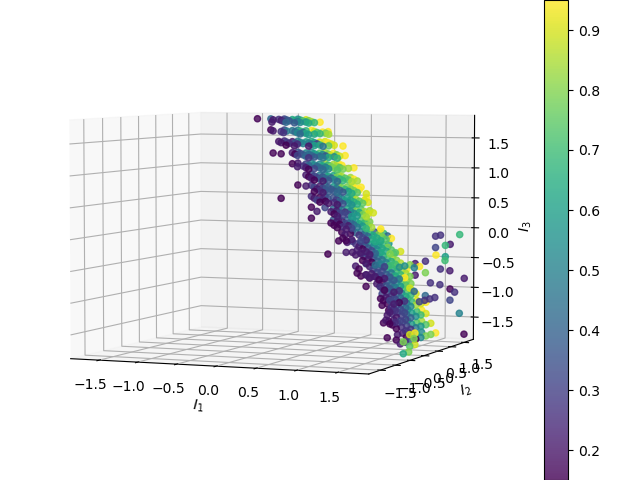

[-3.17522727  2.63403574  1.29922212  1.397013  ]
0.9288379158666492


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


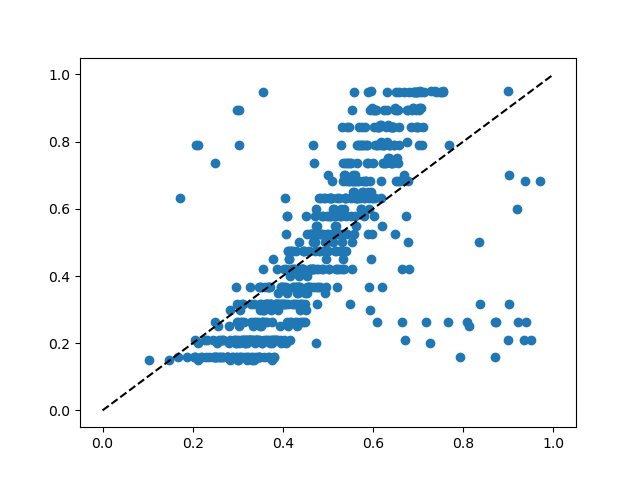

<IPython.core.display.Javascript object>


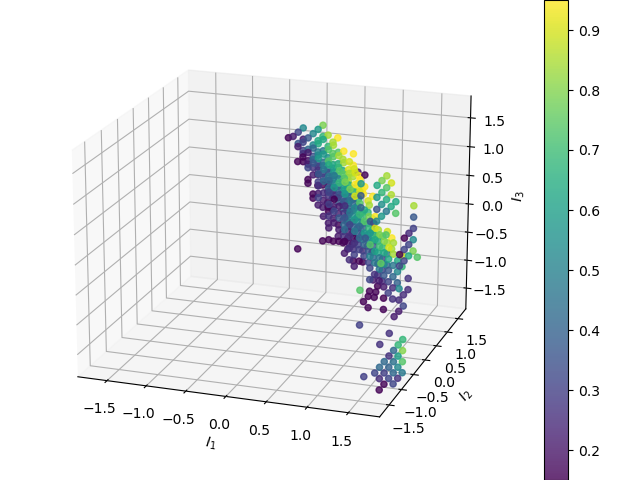

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-2.85753497  2.39999647  1.24012634  1.03226858]
0.9260955039906957


<IPython.core.display.Javascript object>


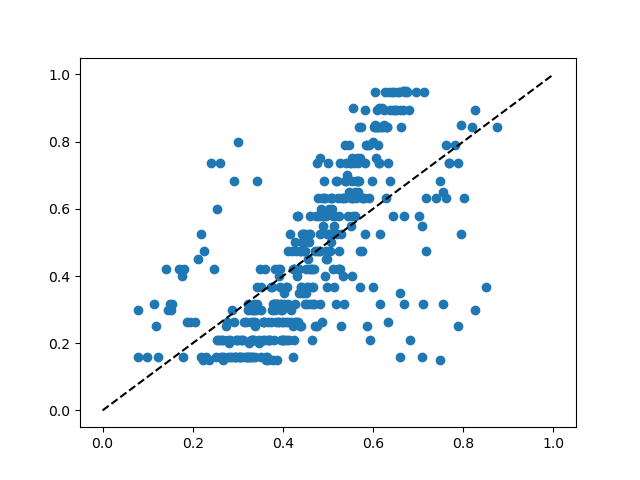

In [56]:
nt_weights = []
nt_amps = []
nt_probs = []
for nt in nontargets:
    print(vcd.get_cell_type_for_cell(nt))
    weights, amps, probs = getWeights(p, nt, clusters_nt, negll_thr, show_clusters=True)
    nt_weights.append(weights)
    nt_amps.append(amps)
    nt_probs.append(probs)

nt_weights = np.vstack((nt_weights))

In [57]:
nt_weights

array([[-6.53564193, -6.149421  , -2.96013467, -3.01433535],
       [-4.20781946, -4.07088449, -2.11506443, -2.0416061 ],
       [-3.17522727,  2.63403574,  1.29922212,  1.397013  ],
       [-2.85753497,  2.39999647,  1.24012634,  1.03226858]])

ON Parasol


<IPython.core.display.Javascript object>


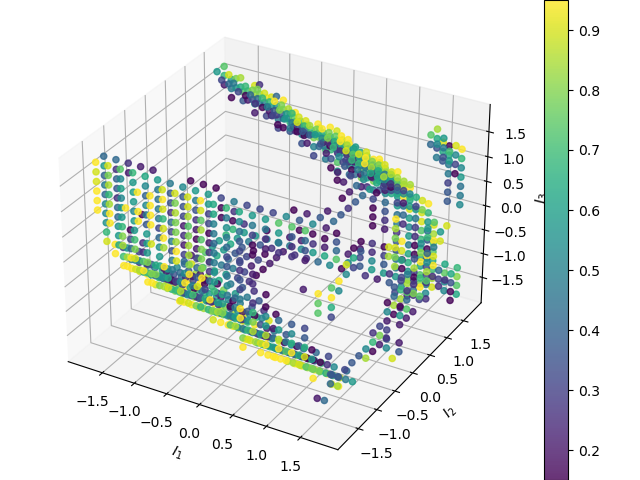

/tmp/ipykernel_26826/2848077523.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


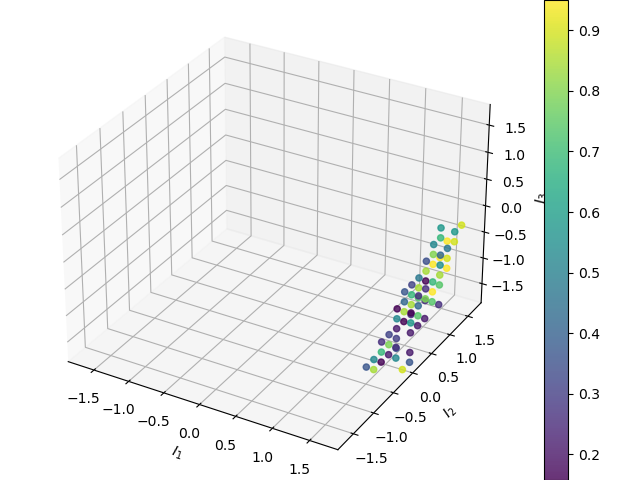

[-1.82328655  1.15002458  0.67392703  0.3019961 ]
0.9596007956701382


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


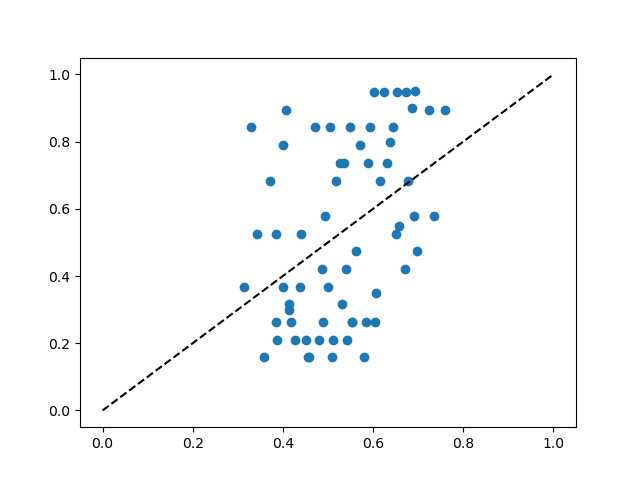

/tmp/ipykernel_26826/2848077523.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


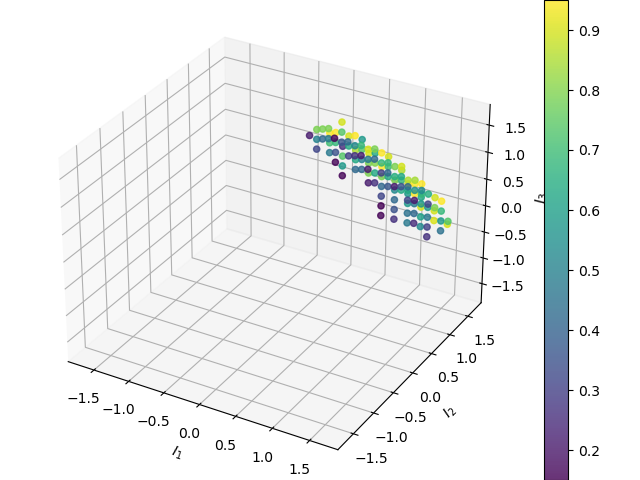

[-16.01417338   2.99218357   8.56480794   4.31189202]
0.8503558301034522


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


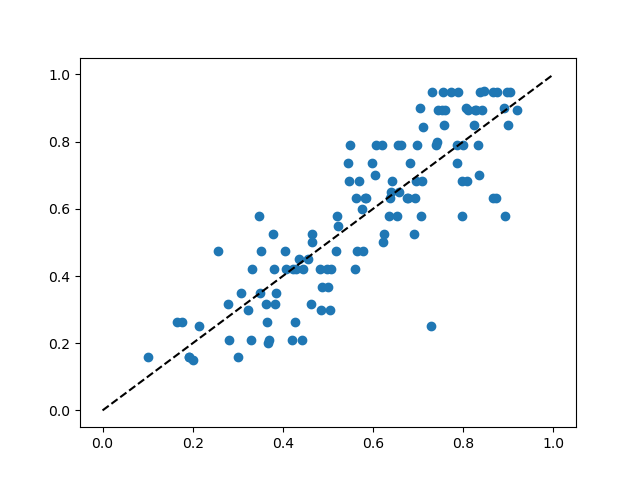

<IPython.core.display.Javascript object>


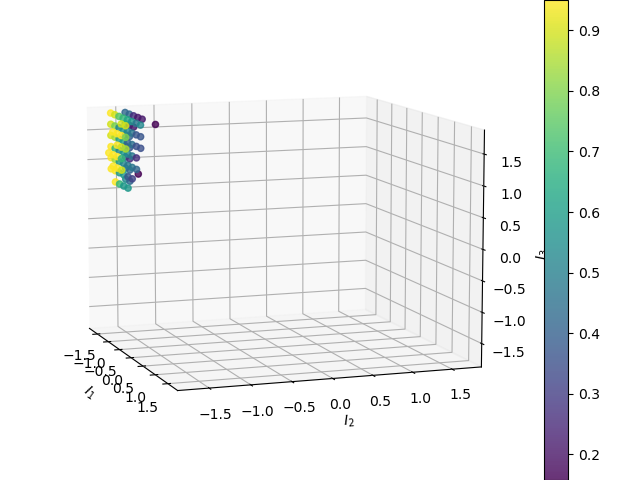

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-20.30907947  -2.07155389 -11.35046712   0.30002159]
0.8002501434395465


<IPython.core.display.Javascript object>


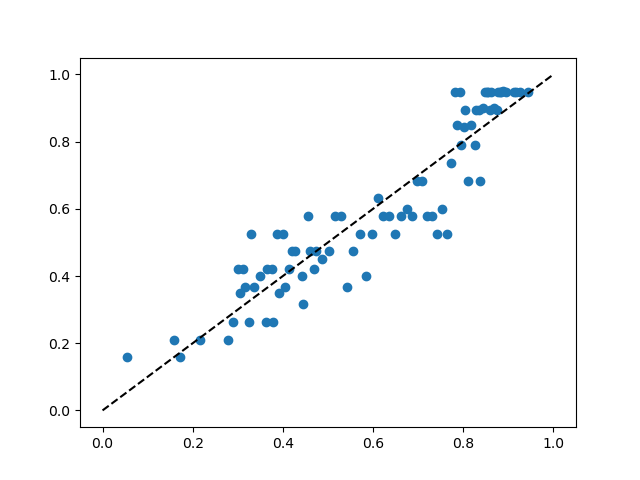

<IPython.core.display.Javascript object>


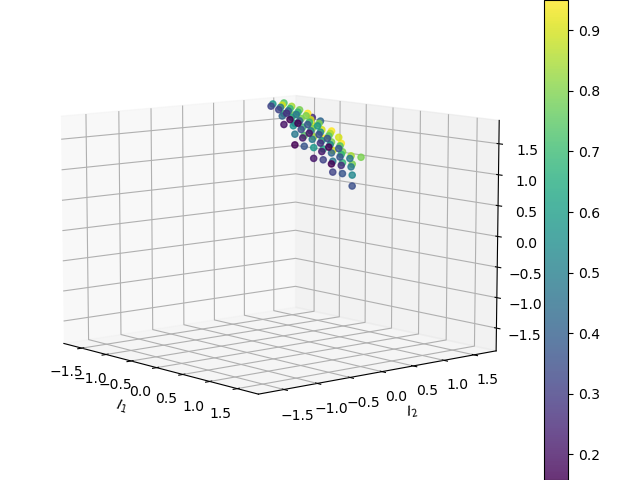

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-15.74938662   3.03141604   7.65812631   5.95162979]
0.8754603005210081


<IPython.core.display.Javascript object>


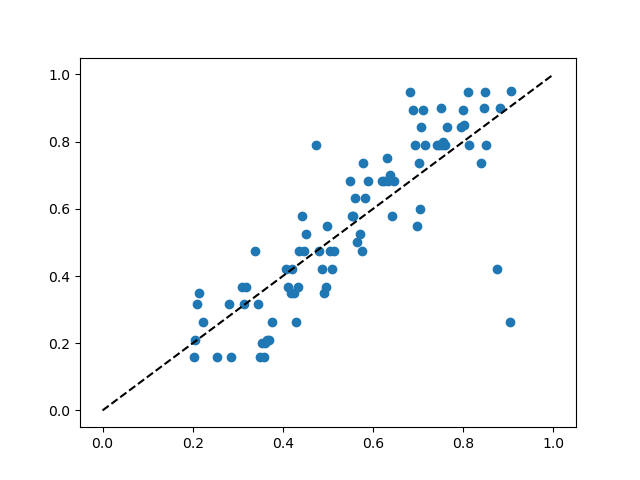

<IPython.core.display.Javascript object>


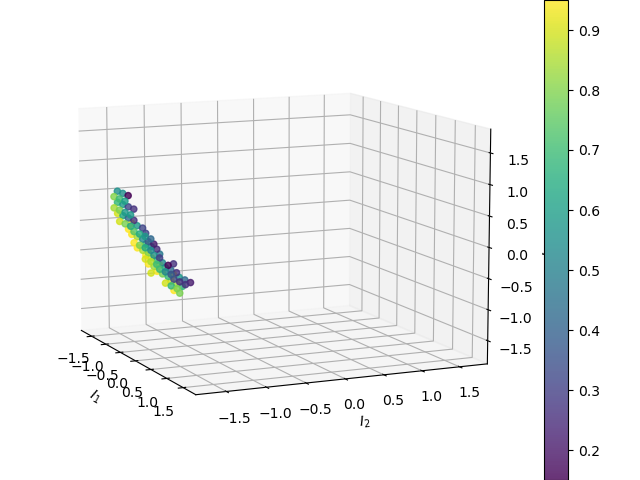

[-19.58665435  -3.58993968 -11.24780907  -6.04367486]
0.8172993071510846


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


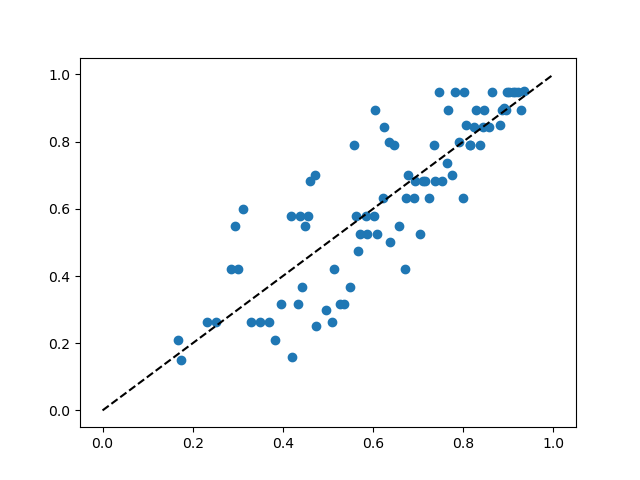

<IPython.core.display.Javascript object>


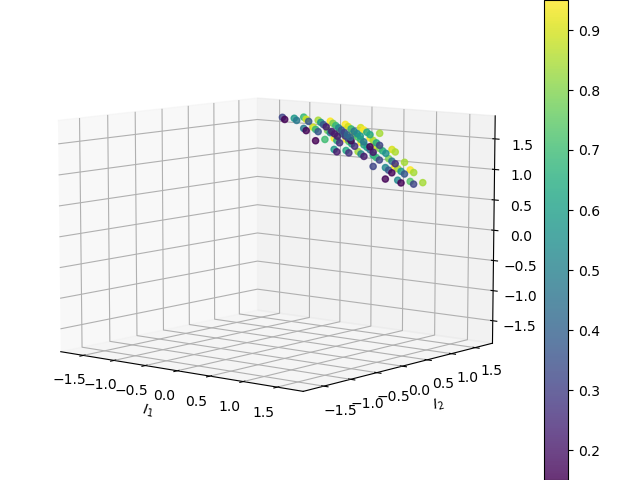

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-18.76373588   3.64834406   6.77554884   8.56304603]
0.8333003905683904


<IPython.core.display.Javascript object>


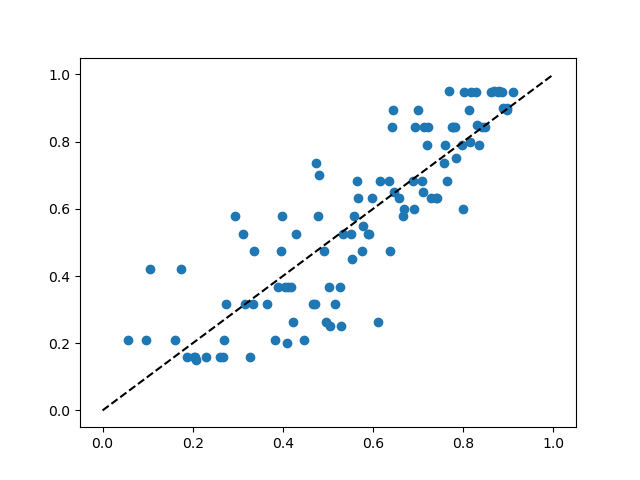

<IPython.core.display.Javascript object>


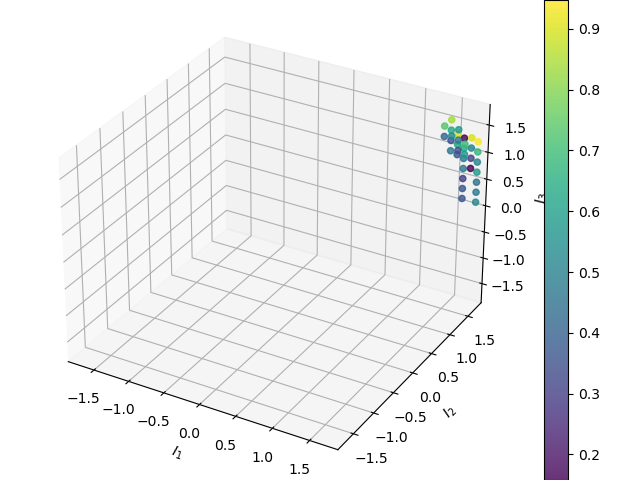

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-7.89656257  1.52517156  2.40307962  1.53687298]
0.9625152983416819


<IPython.core.display.Javascript object>


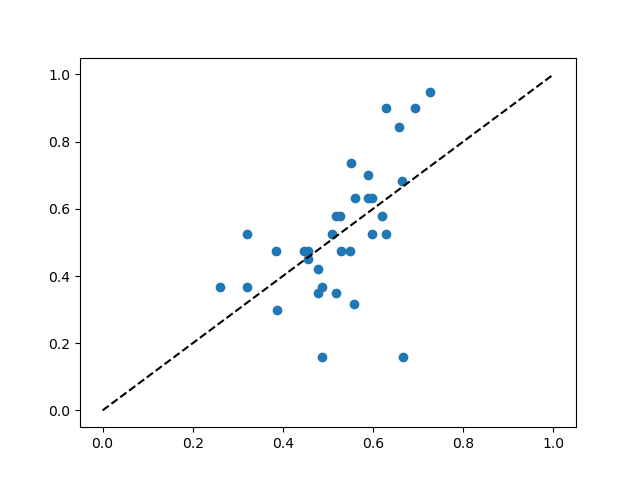

<IPython.core.display.Javascript object>


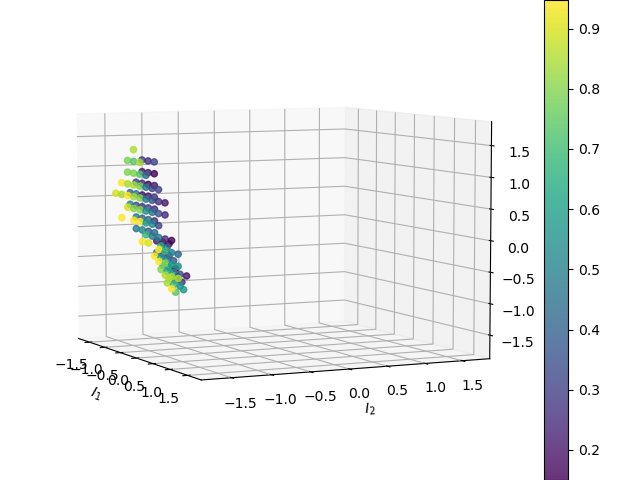

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-14.40029149  -2.0722841   -9.09989892  -2.00280616]
0.8800952933190556


<IPython.core.display.Javascript object>


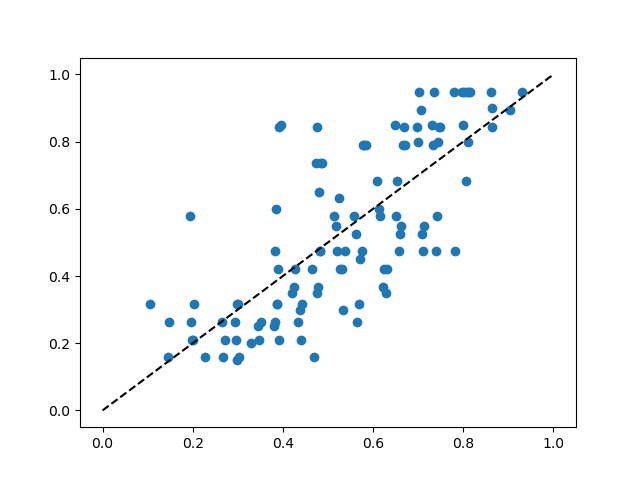

<IPython.core.display.Javascript object>


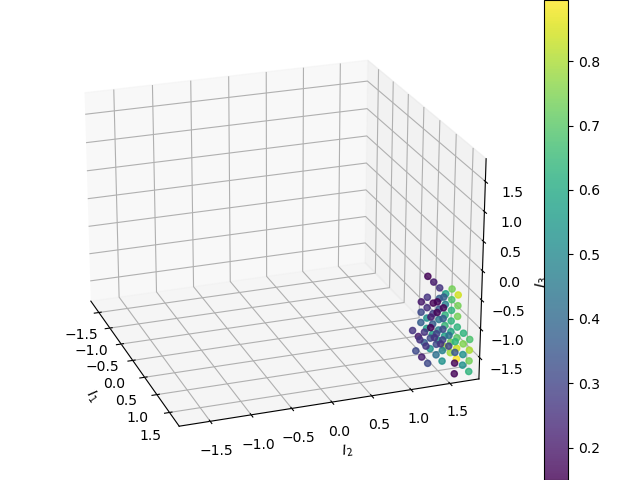

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-11.12978709   1.19785844   5.24996944  -0.48852774]
0.9179068888047681


<IPython.core.display.Javascript object>


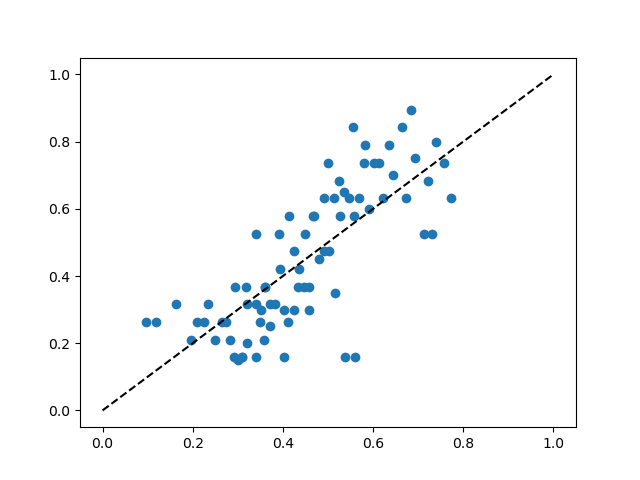

<IPython.core.display.Javascript object>


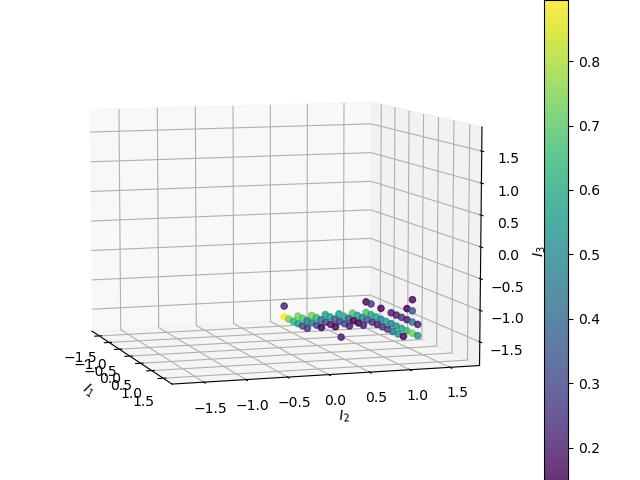

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-6.89258534 -0.50257564  0.23363708 -3.26532062]
0.9423250491742821


<IPython.core.display.Javascript object>


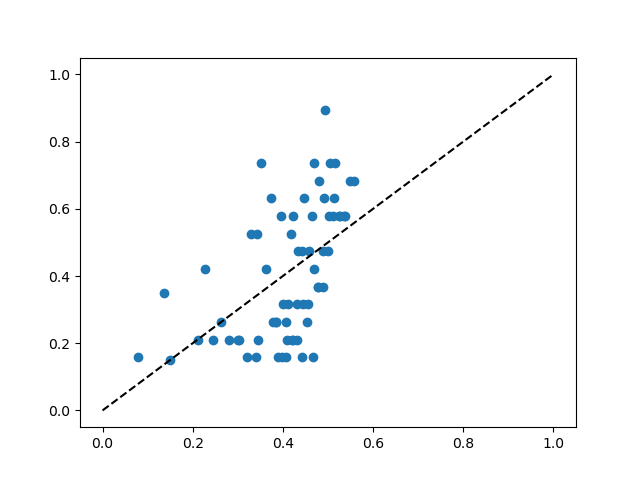

<IPython.core.display.Javascript object>


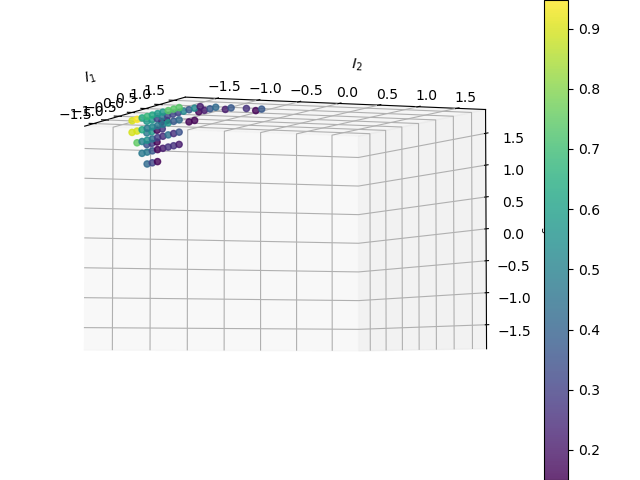

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-8.196495   -0.36992052 -2.80110957  2.20114266]
0.9225643330191825


<IPython.core.display.Javascript object>


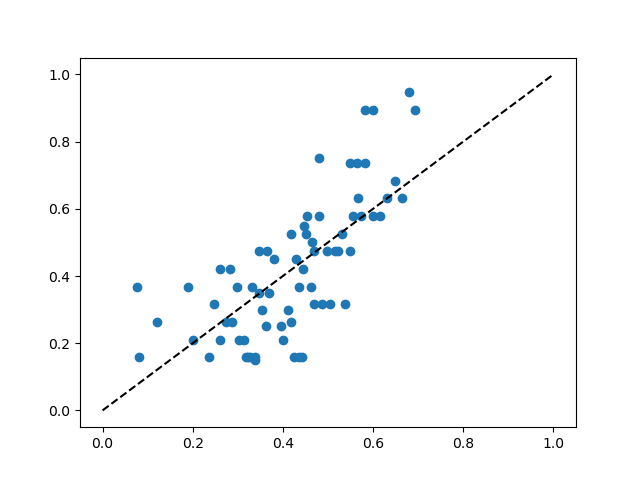

<IPython.core.display.Javascript object>


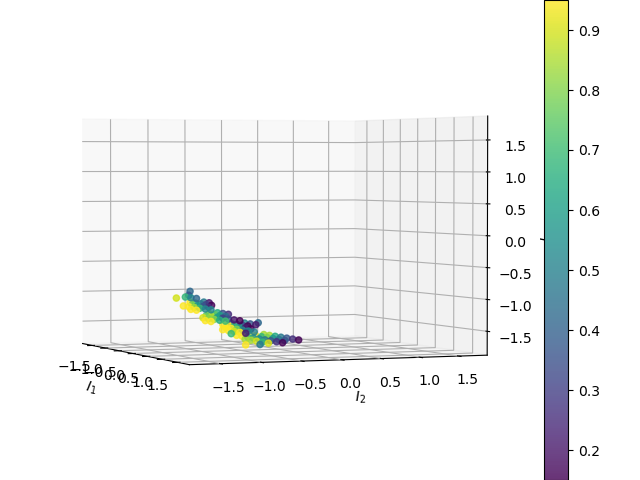

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-17.71908763  -2.24247675  -6.3476681   -9.72790611]
0.8356718378870105


<IPython.core.display.Javascript object>


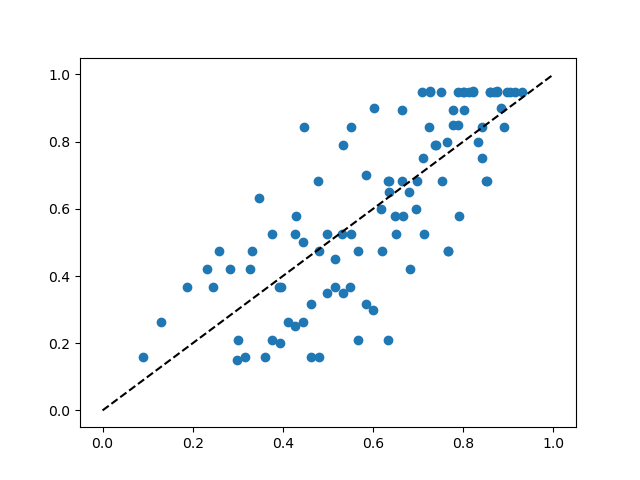

<IPython.core.display.Javascript object>


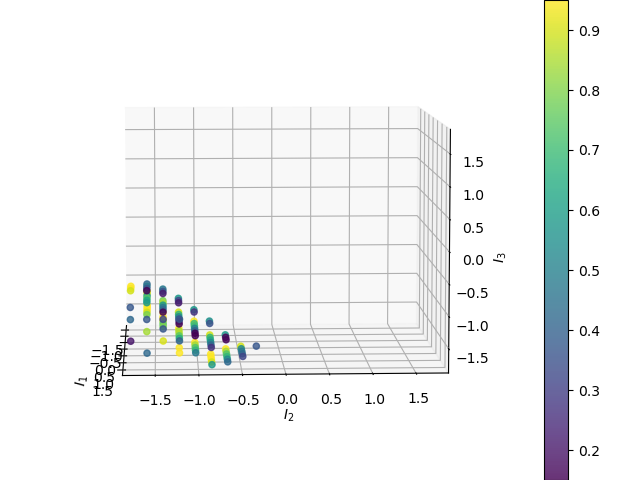

/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-9.08909926 -1.30305752 -4.43019577 -4.28300488]
0.8985311528655758


<IPython.core.display.Javascript object>


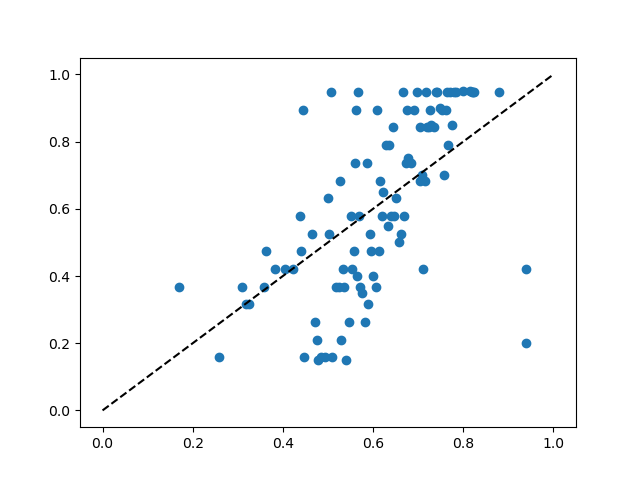

<IPython.core.display.Javascript object>


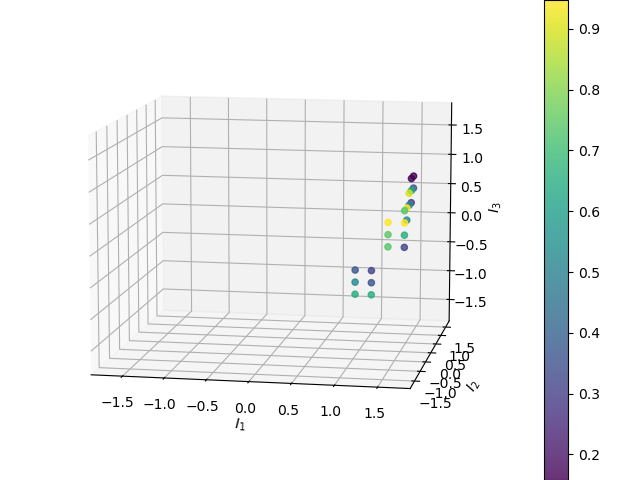

[-5.49984517 -0.74363618 -3.90662692  1.69707506]
0.9114350005456868


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


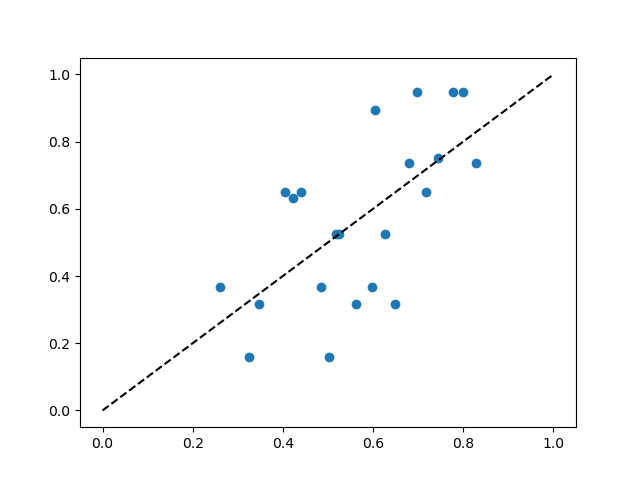

<IPython.core.display.Javascript object>


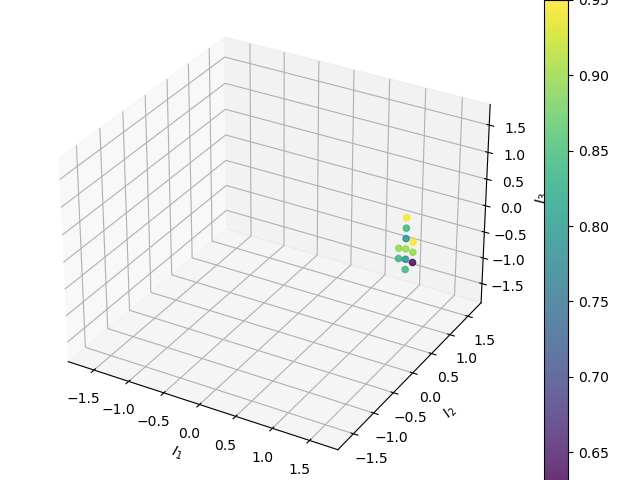

[ 5.32831863 -2.36180892  0.77160225  1.36899171]
0.6024077153401096


/tmp/ipykernel_26826/2848077523.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


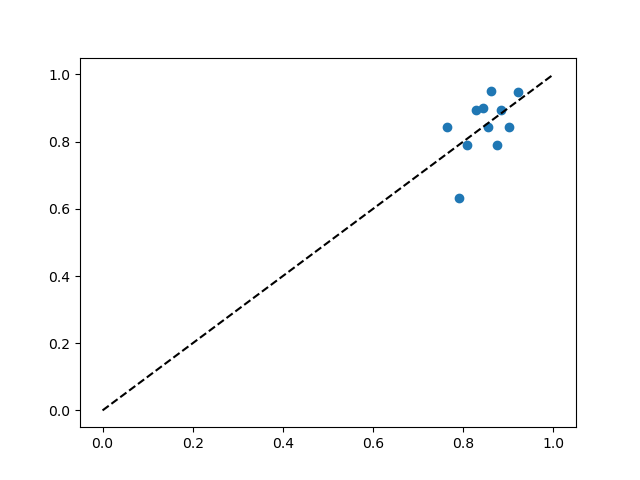

In [73]:
t_weights = []
t_amps = []
t_probs = []
for t in targets:
    print(vcd.get_cell_type_for_cell(t))
    weights, amps, probs = getWeights(p, t, clusters_t, negll_thr, show_clusters=True)
    t_weights.append(weights)
    t_amps.append(amps)
    t_probs.append(probs)

t_weights = np.vstack((t_weights))

In [75]:
t_weights

array([[-16.01417338,   2.99218357,   8.56480794,   4.31189202],
       [-20.30907947,  -2.07155389, -11.35046712,   0.30002159],
       [-15.74938662,   3.03141604,   7.65812631,   5.95162979],
       [-19.58665435,  -3.58993968, -11.24780907,  -6.04367486],
       [-18.76373588,   3.64834406,   6.77554884,   8.56304603],
       [-14.40029149,  -2.0722841 ,  -9.09989892,  -2.00280616],
       [-11.12978709,   1.19785844,   5.24996944,  -0.48852774],
       [ -6.89258534,  -0.50257564,   0.23363708,  -3.26532062],
       [ -8.196495  ,  -0.36992052,  -2.80110957,   2.20114266],
       [-17.71908763,  -2.24247675,  -6.3476681 ,  -9.72790611],
       [ -9.08909926,  -1.30305752,  -4.43019577,  -4.28300488]])

In [76]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [77]:
I_max = 1.78125
selec_vals = np.zeros(len(t_weights))
x_vals = np.zeros((len(t_weights), 3))
for i in range(len(t_weights)):
    print(i)
    T_t = cp.Variable(1)
    T_n = cp.Variable(1)
    x = cp.Variable(3)

    constraints = [
        -t_weights[i, 0] - t_weights[i,1:] @ x  <= T_t,
        nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
        x <= I_max,
        -I_max <= x, 
    ]

    objective_function = cp.exp(T_n) + cp.exp(T_t)

    objective = cp.Minimize(objective_function)
    prob = cp.Problem(objective, constraints)
    opt_val  = prob.solve()
    print(f"Optimal value {opt_val}")

    print(f"optimal p_t {compute_pt(T_t.value)[0]}")
    print(f"optimal p_n {compute_pn(T_n.value)[0]}")
    print(f"optimal T_t {T_t.value[0]}")
    print(f"optimal T_n {T_n.value[0]}")
    print(x.value)

    selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
    x_vals[i] = x.value

0
Optimal value 0.18558286121180612
optimal p_t 0.9200608506148527
optimal p_n 0.08983197172446945
optimal T_t -2.443174097268061
optimal T_n -2.31568828441239
[-1.49699177  1.78124999  1.78124998]
1
Optimal value 0.3571481094174971
optimal p_t 0.8086042611501366
optimal p_n 0.10750082086353274
optimal T_t -1.4409664112715779
optimal T_n -2.1165271104399173
[-0.48157709 -1.78125     1.78125   ]
2
Optimal value 0.0918901972534369
optimal p_t 0.9590276257991969
optimal p_n 0.04686322583930258
optimal T_t -3.153021841731192
optimal T_n -3.0125251422930663
[-1.76154281  1.78124998  1.78124997]
3
Optimal value 0.04614412515809461
optimal p_t 0.9963510408743785
optimal p_n 0.04075064166096011
optimal T_t -5.609657690302723
optimal T_n -3.1586794743632813
[ 1.56106836 -1.78124994 -1.78124981]
4
Optimal value 0.14043010129275352
optimal p_t 0.9443952418395064
optimal p_n 0.07540224813673181
optimal T_t -2.8322759908882245
optimal T_n -2.5065216893751896
[-1.56944083  1.78124999  1.78124999]
5


In [78]:
selec_vals

array([0.83740997, 0.72167864, 0.9140845 , 0.9557491 , 0.87318572,
       0.85943715, 0.33103119, 0.35418391, 0.66154982, 0.95867202,
       0.94758208])

In [79]:
selec_vals[np.argsort(selec_vals)]

array([0.33103119, 0.35418391, 0.66154982, 0.72167864, 0.83740997,
       0.85943715, 0.87318572, 0.9140845 , 0.94758208, 0.9557491 ,
       0.95867202])

In [80]:
x_vals[np.argsort(selec_vals)]

array([[ 0.75057079,  1.78125   , -1.78125   ],
       [-0.63559415,  1.78124999, -1.78125   ],
       [-0.21727428, -1.78125   ,  1.78125   ],
       [-0.48157709, -1.78125   ,  1.78125   ],
       [-1.49699177,  1.78124999,  1.78124998],
       [ 1.50538951, -1.78124999, -1.78124995],
       [-1.56944083,  1.78124999,  1.78124999],
       [-1.76154281,  1.78124998,  1.78124997],
       [ 1.56106836, -1.78124988, -1.78124986],
       [ 1.56106836, -1.78124994, -1.78124981],
       [ 1.56106798, -1.7812498 , -1.78124917]])

In [81]:
selec_vec = x_vals[np.argsort(selec_vals)[-1]]

<IPython.core.display.Javascript object>


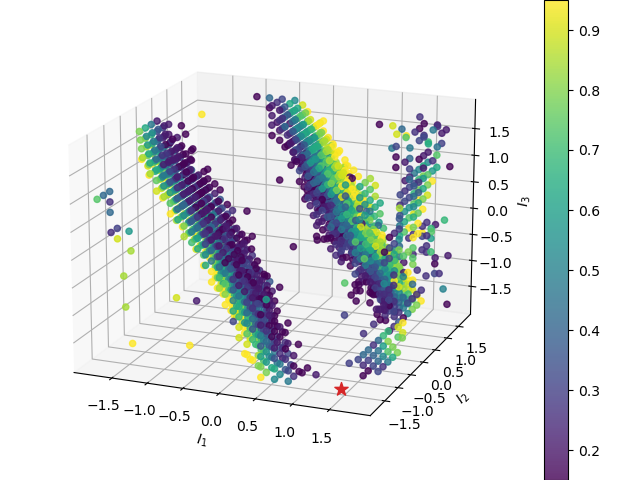

/tmp/ipykernel_26826/2848077523.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-6.53564193 -6.149421   -2.96013467 -3.01433535]
0.8466117010625431
[-4.20781946 -4.07088449 -2.11506443 -2.0416061 ]
0.9047272231383936
[ 0.87853236 -0.24192129  0.18920753 -0.67683766]
0.9729693992263188
[-3.17522727  2.63403574  1.29922212  1.397013  ]
0.9288379158666492
[-2.85753497  2.39999647  1.24012634  1.03226858]
0.9260955039906957


In [82]:
for nt in nontargets:
    getWeights(p, nt, clusters_nt, negll_thr, selec_vec=selec_vec, show_clusters=False)

<IPython.core.display.Javascript object>


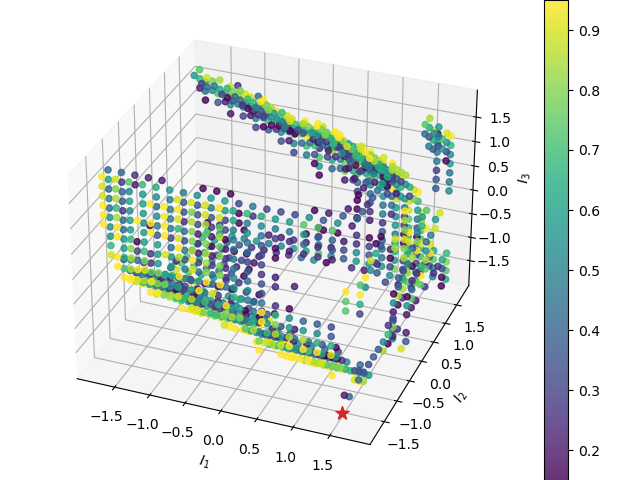

/tmp/ipykernel_26826/2848077523.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-1.82328655  1.15002458  0.67392703  0.3019961 ]
0.9596007956701382
[-16.01417338   2.99218357   8.56480794   4.31189202]
0.8503558301034522
[-20.30907947  -2.07155389 -11.35046712   0.30002159]
0.8002501434395465
[-15.74938662   3.03141604   7.65812631   5.95162979]
0.8754603005210081
[-19.58665435  -3.58993968 -11.24780907  -6.04367486]
0.8172993071510846
[-18.76373588   3.64834406   6.77554884   8.56304603]
0.8333003905683904
[-7.89656257  1.52517156  2.40307962  1.53687298]
0.9625152983416819
[-14.40029149  -2.0722841   -9.09989892  -2.00280616]
0.8800952933190556
[-11.12978709   1.19785844   5.24996944  -0.48852774]
0.9179068888047681
[-6.89258534 -0.50257564  0.23363708 -3.26532062]
0.9423250491742821
[-8.196495   -0.36992052 -2.80110957  2.20114266]
0.9225643330191825
[-17.71908763  -2.24247675  -6.3476681   -9.72790611]
0.8356718378870105
[-9.08909926 -1.30305752 -4.43019577 -4.28300488]
0.8985311528655758
[-5.49984517 -0.74363618 -3.90662692  1.69707506]
0.9114350005456868
[ 

In [83]:
for t in targets:
    getWeights(p, t, clusters_t, negll_thr, selec_vec=selec_vec, show_clusters=False)

In [ ]:
current_levels = np.arange(-19, 20, 2) * 3/128 * 4

In [ ]:
current_levels

In [ ]:
# I1 = 1.21875
I3 = -1.78125

plt.figure()
plt.title('I3 = ' + str(I3))
plt.xlabel('I2')

for I1 in current_levels[-5:]:
    inds = np.where((t_amps[0][:, 0] == I1) & (t_amps[0][:, 2] == I3))[0]
    plt.scatter(t_amps[0][inds][:, 1], t_probs[0][inds], label='I1 = ' + str(I1), alpha=0.5)
    
plt.legend()

In [ ]:
# I1 = 1.21875
I3 = -1.78125

plt.figure()
plt.title('I3 = ' + str(I3))
plt.xlabel('I2')

for I1 in current_levels[-5:]:
    inds = np.where((nt_amps[0][:, 0] == I1) & (nt_amps[0][:, 2] == I3))[0]
    plt.scatter(nt_amps[0][inds][:, 1], nt_probs[0][inds], label='I1 = ' + str(I1), alpha=0.5)
    
plt.legend()